# Importing Libraries

In [ ]:
# import system libs
import os
import time
# import data handling tools
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Activation, GlobalAveragePooling2D
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# For Loading Dataset

In [ ]:
class EyeDiseaseDataset:
  def __init__(self, dataDir):
          self.data_dir = dataDir

  def dataPaths(self):
        filepaths = []
        labels = []
        folds = os.listdir(self.data_dir)
        for fold in folds:
            foldPath = os.path.join(self.data_dir, fold)
            filelist = os.listdir(foldPath)
            for file in filelist:
                fpath = os.path.join(foldPath, file)
                filepaths.append(fpath)
                labels.append(fold)
        return filepaths, labels

  def dataFrame(self, files, labels):
        Fseries = pd.Series(files, name='filepaths')
        Lseries = pd.Series(labels, name='labels')
        return pd.concat([Fseries, Lseries], axis=1)

  def split_(self):
        files, labels = self.dataPaths()
        df = self.dataFrame(files, labels)
        strat = df['labels']
        trainData, dummyData = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=strat)
        strat = dummyData['labels']
        validData, testData = train_test_split(dummyData, train_size=0.5, shuffle=True, random_state=42, stratify=strat)
        return trainData, validData, testData

# Loading Dataset

### Dataset https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification

In [ ]:
dataDir='/content/eye_disease_dataset/dataset/'

In [ ]:
dataSplit = EyeDiseaseDataset(dataDir)
train_data, valid_data, test_data = dataSplit.split_()

# Data Augmentation

In [ ]:
def augment_data( train_df, valid_df, test_df, batch_size=32,img_size = (256,256)):
  channels = 3
  color = 'rgb'

  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
              rotation_range=30,
              horizontal_flip=True,
              vertical_flip=True,
              brightness_range=[0.5, 1.5])

  valid_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

  train_generator = train_datagen.flow_from_dataframe(
              train_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )

  print("Shape of augmented training images:", train_generator.image_shape)

  valid_generator = valid_test_datagen.flow_from_dataframe(
              valid_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )

  print("Shape of validation images:", valid_generator.image_shape)

  test_generator = valid_test_datagen.flow_from_dataframe(
              test_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=False,
              class_mode='categorical'
          )

  print("Shape of test images:", test_generator.image_shape)

  return train_generator, valid_generator, test_generator

In [ ]:
train_augmented, valid_augmented, test_augmented = augment_data(train_data, valid_data, test_data)

Found 3373 validated image filenames belonging to 4 classes.
Shape of augmented training images: (256, 256, 3)
Found 422 validated image filenames belonging to 4 classes.
Shape of validation images: (256, 256, 3)
Found 422 validated image filenames belonging to 4 classes.
Shape of test images: (256, 256, 3)


In [ ]:
classes = len(list(train_augmented.class_indices.keys()))

# Display Augmented Images

In [ ]:
def show_images(gen):

    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    length = len(labels)
    sample = min(length, 10)
    plt.figure(figsize= (15, 17))
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 7 )
        plt.axis('off')
    plt.show()

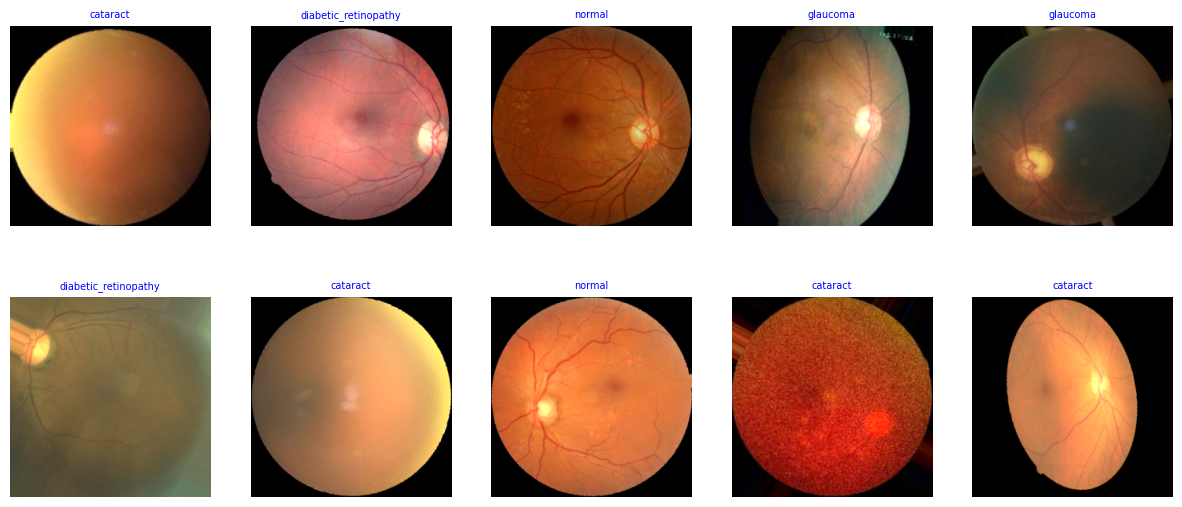

In [ ]:

show_images(train_augmented)

# **Efficientnet B3 Model**

## Downloading & Compiling model

In [ ]:
from tensorflow.keras.applications import EfficientNetB3

classes = len(list(train_augmented.class_indices.keys()))

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)

predictions = Dense(classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

43941136/43941136 [==============================] - 0s 0us/step


## Fitting model

In [ ]:
history = model.fit(
    train_augmented,
    epochs=5,
    validation_data=valid_augmented,
    )

Epoch 1/5
106/106 [==============================] - 100s 807ms/step - loss: 0.6112 - accuracy: 0.7495 - val_loss: 0.5740 - val_accuracy: 0.7607
Epoch 2/5
106/106 [==============================] - 81s 762ms/step - loss: 0.4445 - accuracy: 0.8280 - val_loss: 0.4287 - val_accuracy: 0.8175
Epoch 3/5
106/106 [==============================] - 84s 798ms/step - loss: 0.3822 - accuracy: 0.8488 - val_loss: 0.4294 - val_accuracy: 0.8318
Epoch 4/5
106/106 [==============================] - 96s 910ms/step - loss: 0.3447 - accuracy: 0.8698 - val_loss: 0.4225 - val_accuracy: 0.8507
Epoch 5/5
106/106 [==============================] - 83s 784ms/step - loss: 0.3110 - accuracy: 0.8826 - val_loss: 0.3638 - val_accuracy: 0.8626


## Results

Training Accuracy: 0.8825970888137817
Validation Accuracy: 0.8625592589378357


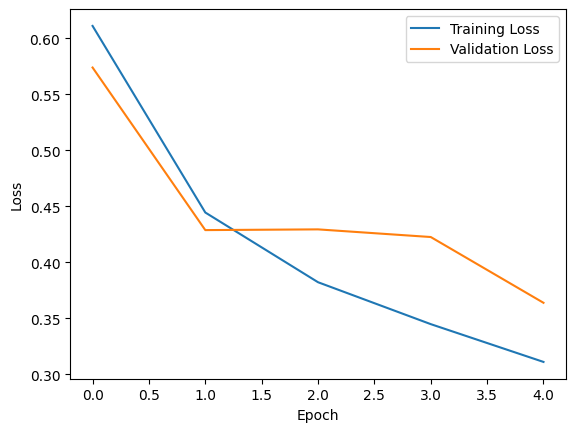

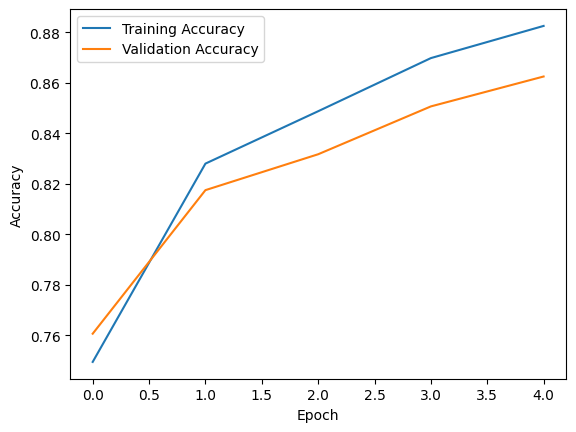

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Display Actual Vs Predicted

1/1 [==============================] - 2s 2s/step


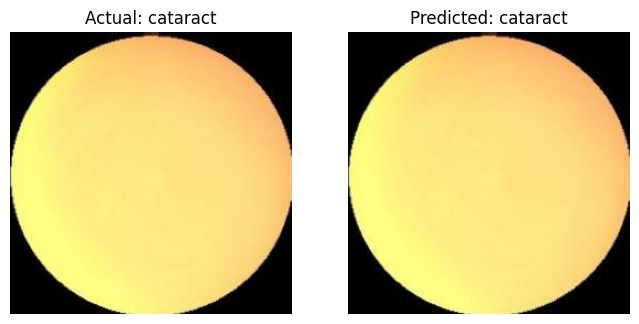

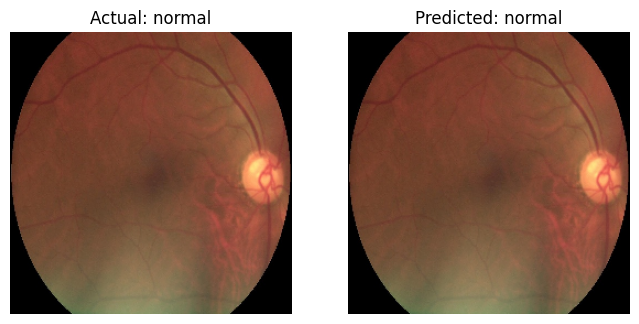

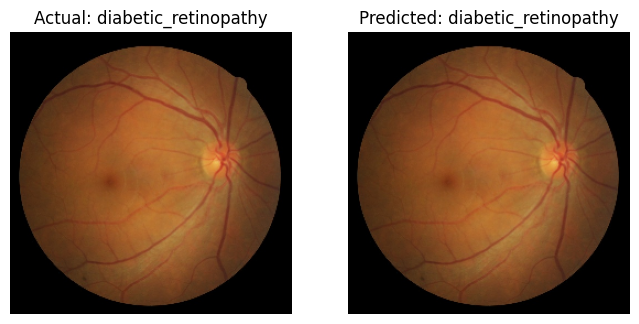

In [ ]:
def plot_actual_vs_predicted(model, test_data, num_samples=3):
    # Get a batch of test data
  test_images, test_labels = next(iter(test_data))

  predictions = model.predict(test_images)

  class_labels = list(train_augmented.class_indices.keys())

  sample_indices = np.random.choice(range(len(test_images)), num_samples, replace=False)
      # Plot the images with actual and predicted labels
  for i in sample_indices:
    actual_label = class_labels[np.argmax(test_labels[i])]
    predicted_label = class_labels[np.argmax(predictions[i])]
    plt.figure(figsize=(8, 4))
    # Actual Image
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].astype(np.uint8))
    plt.title(f'Actual: {actual_label}')
    plt.axis('off')
    # Predicted Image
    plt.subplot(1, 2, 2)
    plt.imshow(test_images[i].astype(np.uint8))
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()

plot_actual_vs_predicted(model, test_augmented)